###<b> Mounting the Drive

In [1]:
#Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###<b>Loading libraries</b>

In [2]:
#Importing libraries required to load the data

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, LeakyReLU, GlobalAvgPool2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers

#to ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Remove the limit from the number of displayed columns and rows. It helps to see the entire dataframe while printing it
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

### <b>Load the data</b>

**Note:** 
- You must download the dataset from the link provided on Olympus and upload the same on your Google drive before executing the code in the next cell.
- In case of any error, please make sure that the path of the file is correct as the path may be different for you.

In [3]:
#Storing the path of the data file from the Google drive
path = '/content/drive/MyDrive/Colab Notebooks/cell_images.zip'

#The data is provided as a zip file so we need to extract the files from the zip file
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data which further contains the different sizes of images for parasitized and uninfected cells within the respective folder name. 

The size of all images must be the same and should be converted to 4D arrays so that they can be used as an input for the convolutional neural network. Also, we need to create the labels for both types of images to be able to train and test the model. 

Let's do the same for the training data first and then we will use the same code for the test data as well.

In [4]:
#Storing the path of the extracted "train" folder 
train_dir = '/content/cell_images/train'

#Size of image so that each image has the same size
SIZE = 64

#Empty list to store the training images after they are converted to NumPy arrays
train_images = []

#Empty list to store the training labels (0 - uninfected, 1 - parasitized)
train_labels = []

In [5]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "train" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(train_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(train_dir + folder_name + image_name)

            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))

            #Converting images to arrays and appending that array to the empty list defined above
            train_images.append(np.array(image))

            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                train_labels.append(1)
            else:
                train_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [6]:
#Storing the path of the extracted "test" folder 
test_dir = '/content/cell_images/test'

#Size of image so that each image has the same size (it must be same as the train image size)
SIZE = 64

#Empty list to store the testing images after they are converted to NumPy arrays
test_images = []

#Empty list to store the testing labels (0 - uninfected, 1 - parasitized)
test_labels = []

In [7]:
#We will run the same code for "parasitized" as well as "uninfected" folders within the "test" folder
for folder_name in ['/parasitized/', '/uninfected/']:
    
    #Path of the folder
    images_path = os.listdir(test_dir + folder_name)

    for i, image_name in enumerate(images_path):
        try:
            #Opening each image using the path of that image
            image = Image.open(test_dir + folder_name + image_name)
            
            #Resizing each image to (64,64)
            image = image.resize((SIZE, SIZE))
            
            #Converting images to arrays and appending that array to the empty list defined above
            test_images.append(np.array(image))
            
            #Creating labels for parasitized and uninfected images
            if folder_name=='/parasitized/':
                test_labels.append(1)
            else:
                test_labels.append(0)
        except Exception:
            pass       

#Converting lists to arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels)

###<b>Normalize the images

In [8]:
# try to normalize the train and test images by dividing it by 255 and convert them to float32 using astype function
train_images = (train_images).astype('float32') / 255
test_images = (test_images).astype('float32') / 255

###<B>One Hot Encoding on the train and test labels

In [9]:
# Encoding Train Labels
train_labels=to_categorical(train_labels,2)
# Similarly let us try to encode test labels
test_labels=to_categorical(test_labels,2)

### **Base Model**

**Note:** The Base Model has been fully built and evaluated with all outputs shown to give an idea about the process of the creation and evaluation of the performance of a CNN architecture. A similar process can be followed in iterating to build better-performing CNN architectures.

####<b> Importing the required libraries

In [10]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the model

In [11]:
#creating sequential model
model=Sequential()
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(2,activation="softmax"))#2 represent output layer neurons 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compiling the model

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks 

In [13]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and train our Model

In [14]:
#Fit the model with min batch size as 32 can tune batch size to some factor of 2^power ] 
history=model.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 104s 165ms/step - loss: 0.4039 - accuracy: 0.8056 - val_loss: 0.1776 - val_accuracy: 0.9599
Epoch 2/20
624/624 [==============================] - 93s 150ms/step - loss: 0.1117 - accuracy: 0.9622 - val_loss: 0.1180 - val_accuracy: 0.9856
Epoch 3/20
624/624 [==============================] - 92s 148ms/step - loss: 0.0917 - accuracy: 0.9685 - val_loss: 0.0946 - val_accuracy: 0.9840
Epoch 4/20
624/624 [==============================] - 94s 151ms/step - loss: 0.0771 - accuracy: 0.9743 - val_loss: 0.0912 - val_accuracy: 0.9826
Epoch 5/20
624/624 [==============================] - 92s 148ms/step - loss: 0.0776 - accuracy: 0.9751 - val_loss: 0.0902 - val_accuracy: 0.9816
Epoch 6/20
624/624 [==============================] - 97s 155ms/step - loss: 0.0680 - accuracy: 0.9774 - val_loss: 0.0650 - val_accuracy: 0.9856
Epoch 7/20
624/624 [==============================] - 91s 146ms/step - loss: 0.0663 - accuracy: 0.9766 - val_loss: 0.0655 - val_a

####<b> Evaluating the model on test data

In [15]:
accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 3s 39ms/step - loss: 0.0613 - accuracy: 0.9842

 Test_Accuracy:- 0.9842307567596436


<b> Plotting the confusion matrix

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1300
           1       0.99      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



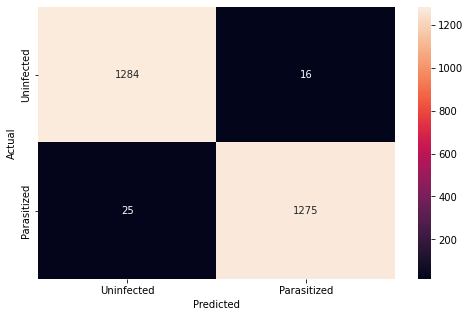

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

pred = model.predict(test_images)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
cm = confusion_matrix(y_true,pred)
plt.figure(figsize=(8,5))
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Observations:** 
- Precision and Recall are the same.
- There were 29 cells that were predicted as parasitized that were not.
- There were 27 cells that were predicted as uninfected that were not.
- Accuracy/ Precision/ Recall/ F1 are all at 0.98. This is pretty good, but since we are creating a model for diagnostics we really want that higher. The reason is that if we say someone does not have malaria who really does, then it could be life threatening if we wait longer to give treatements.

<b>Plotting the train and validation curves

In [17]:
# function to plot train and validation accuracy 
def plot_accuracy(history):
    N = len(history.history["accuracy"])
    plt.figure(figsize=(7,7))
    plt.plot(np.arange(0, N), history.history["accuracy"], label="train_accuracy", ls='--')
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy", ls='--')
    plt.title("Accuracy vs Epoch")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc="upper left")

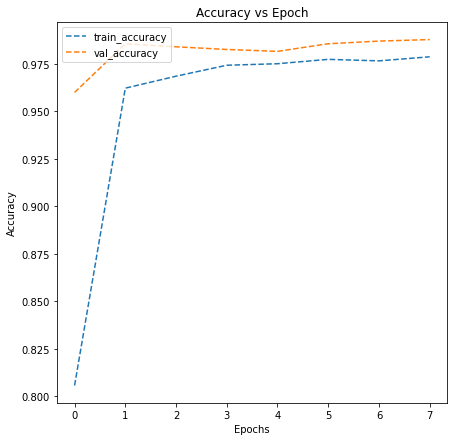

In [18]:
plot_accuracy(history)



* Here we can clearly observe that the training and valiation accuracy are increasing 
* And we can also notice that validation accuracy is slightly higher than the train accuracy
- Train accuracy is at 0.80 at epoch 0 and quickly increases which is expected.

So now let's try to build another model with few more add on layers and try to check if we can try to improve the model. Therefore try to build a model by adding few layers if required and altering the activation functions.

###<b> Model 1
####<b> Trying to improve the performance of our model by adding new layers


In [19]:
#Clearing backend
from tensorflow.keras import backend
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from random import shuffle

backend.clear_session()
#Fixing the seed for random number generators so that we can ensure we receive the same output everytime
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [20]:
#creating sequential model
model1=Sequential()
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu",input_shape=(64,64,3)))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
model1.add(MaxPooling2D(pool_size=2))
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(512,activation="relu"))
model1.add(Dropout(0.4))
model1.add(Dense(2,activation="softmax"))
#This model is the same as the original model, but just has these lines added each twice to introduce 2 new layers:
#model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation="relu"))
#model.add(MaxPooling2D(pool_size=2))
#model.add(Dropout(0.2))
#Let's see if this increases our metrics to 0.99 or even marginally.

# Build the model here

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

####<b> Compiling the model

In [21]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> Using Callbacks

In [22]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [23]:
history1=model1.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,  validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 97s 153ms/step - loss: 0.3134 - accuracy: 0.8445 - val_loss: 0.0779 - val_accuracy: 0.9900
Epoch 2/20
624/624 [==============================] - 91s 146ms/step - loss: 0.0962 - accuracy: 0.9675 - val_loss: 0.0886 - val_accuracy: 0.9766
Epoch 3/20
624/624 [==============================] - 90s 145ms/step - loss: 0.0793 - accuracy: 0.9741 - val_loss: 0.0950 - val_accuracy: 0.9716


<b> Observations
- A trade off is the amount of computation that has to be done with the addition of layers. Model 1 took longer to fit than the initial model. Looking at just the first epoch, "model 1" took 7-10 seconds longer than "model".

####<b> Evaluating the model

In [24]:
accuracy1 = model1.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy1[1])

82/82 [==============================] - 3s 38ms/step - loss: 0.0658 - accuracy: 0.9827

 Test_Accuracy:- 0.982692301273346


<b> Plotting the confusion matrix

In [25]:
def confusion(model):
  pred = model.predict(test_images)
  pred = np.argmax(pred,axis = 1) 
  y_true = np.argmax(test_labels,axis = 1)

#Printing the classification report
  print(classification_report(y_true,pred))

#Plotting the heatmap using confusion matrix
  cm = confusion_matrix(y_true,pred)
  plt.figure(figsize=(8,5))
  sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels=['Uninfected', 'Parasitized'], yticklabels=['Uninfected', 'Parasitized'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



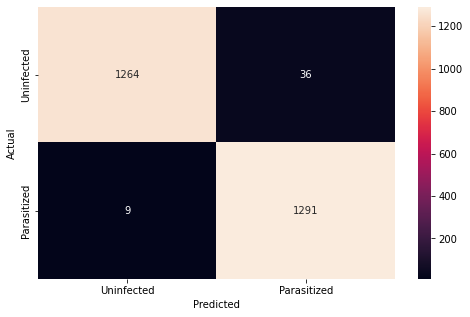

In [26]:
confusion(model1)

####<b>Observations:</b><br>
- The Model1 is performing very similarly to model. It has a few less false negatives and a few more false positives.
- It has one less incorrect prediction! Improvement! (but not really)

<b> Plotting the Train and validation curves

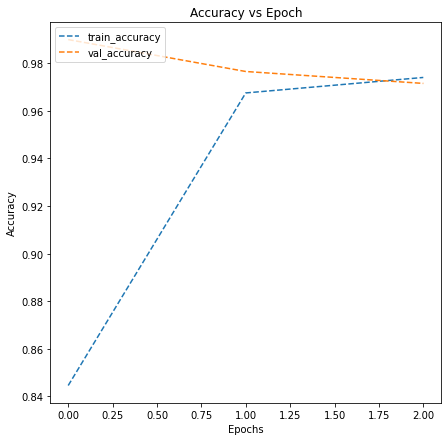

In [27]:
plot_accuracy(history1)

####<b>Observations:</b><br>
- Validation accuracy started really high well above 0.98.
- The train curve is a very clear elbow.
- This model may be overfitting a bit. At 2 epochs, the validation accuracy is already lower than the training accuracy.

####<b>Think about it:</b><br>
Now let's build a model with LeakyRelu as the activation function  

*  Can the model performance be improved if we change our activation function to LeakyRelu?
*  Can BatchNormalization improve our model?

Let us try to build a model using BatchNormalization and using LeakyRelu as our activation function.

###<b> Model 2 with Batch Normalization

In [28]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()

#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Building the Model

In [29]:
model2 = Sequential()
model2.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(64, 64, 3), padding='same'))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(Dropout(0.2))
model2.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model2.add(LeakyReLU(alpha=0.1))
model2.add(MaxPooling2D(pool_size=2))
model2.add(BatchNormalization())
model2.add(Flatten())
model2.add(Dense(512))
model2.add(LeakyReLU(alpha=0.1))
model2.add(Dropout(rate=0.4))
model2.add(Dense(2,activation="softmax"))
adam = optimizers.Adam(learning_rate=0.001)
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                          

####<b>Compiling the model

In [30]:
model2.compile(loss="binary_crossentropy", optimizer=adam, metrics = ['accuracy'])

<b> Using callbacks

In [31]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and train the model

In [32]:
history2 = model2.fit(train_images,train_labels,batch_size=32,callbacks=callbacks,validation_split=0.2,epochs=20,verbose=1)

Epoch 1/20
624/624 [==============================] - 224s 358ms/step - loss: 0.2608 - accuracy: 0.8887 - val_loss: 0.0100 - val_accuracy: 0.9982
Epoch 2/20
624/624 [==============================] - 222s 356ms/step - loss: 0.0836 - accuracy: 0.9732 - val_loss: 0.0589 - val_accuracy: 0.9882
Epoch 3/20
624/624 [==============================] - 223s 357ms/step - loss: 0.0749 - accuracy: 0.9760 - val_loss: 0.0842 - val_accuracy: 0.9832


<b>Plotting the train and validation accuracy

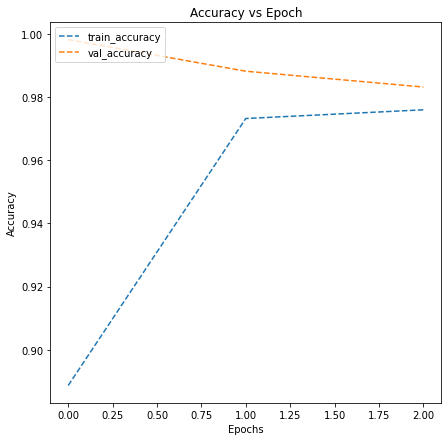

In [33]:
# plotting the accuracies
plot_accuracy(history2)

####<b>Evaluating the model

In [34]:
# Evaluate the model to calculate the accuracy
accuracy = model2.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

82/82 [==============================] - 8s 96ms/step - loss: 0.0644 - accuracy: 0.9788

 Test_Accuracy:- 0.9788461327552795


#####<b>Observations and insights: 
- Validation accuracy at basically 1.0 at epoch 0. This makes me think of a red flag for overfitting.
- The model only ran through 2 epochs. This is due to the callback line of code. Since the validation accuracy did not improve over 2 epochs, the model stops running.

<b> Generate the classification report and confusion matrix 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.99      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



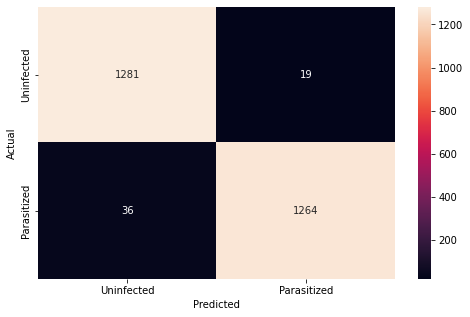

In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

confusion(model2)

##**Observations and Insights:**<br>
- This model has the lowest number of false positives.
- The first time I ran this model, it had the highest number of flase negatives.
- This model performs better than the first two models.
- Only 38 incorrect predictions in the testing set of 2600.




####**Think About It :**<br>

* Can we improve the model with Image Data Augmentation?
* References to image data augmentation can be seen below:
  *   [Image Augmentation for Computer Vision](https://www.mygreatlearning.com/blog/understanding-data-augmentation/)
  *   [How to Configure Image Data Augmentation in Keras?](https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/)





###<b>Model 3 with Data Augmentation

In [36]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

####<b> Using image data generator

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Using ImageDataGenerator to generate images

train_datagen = ImageDataGenerator(horizontal_flip=True, 
                                  zoom_range = 0.5, rotation_range=30)
val_datagen  = ImageDataGenerator()

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = X_train, y = y_train, batch_size=64, seed=42, shuffle=True)     

# Flowing validation images using val_datagen generator
val_generator =  val_datagen.flow(x= X_val, y = y_val, batch_size=64, seed=42, shuffle=True)

####**Think About It :**<br>

*  Check if the performance of the model can be improved by changing different parameters in the ImageDataGenerator.



####<B>Visualizing Augmented images

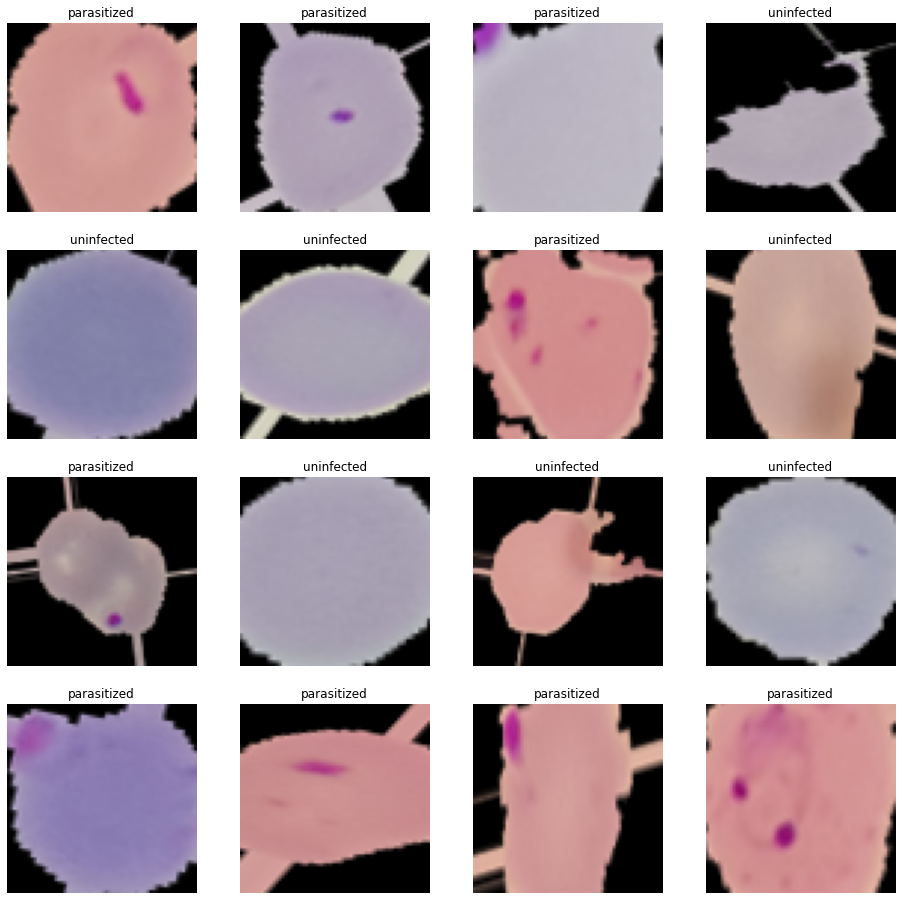

In [38]:
#Creating an iterable for images and labels from the training data
images, labels = next(train_generator)

#Plotting 16 images from the training data
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[1] == 1: 
        ax.set_title('parasitized')
    else:
        ax.set_title('uninfected')
    ax.axis('off')

#####<b>Observations and insights: 
- In the image generation proces, we flipped images and manipulated them in other ways.
- Many of the images now have rectangles extending from the sides of the cell.
- None in the small set have what seems to be malaria on the rectangles extending.
- I am unsure at this point if this image generation and augmentation will make a difference. We can test by running this new augmented data on the same model as model 2.

####<b>Building the Model

In [39]:
model3 = Sequential()

# Build the model here
model3 = Sequential()
model3.add(Conv2D(filters = 32, kernel_size=(3,3), input_shape=(64, 64, 3), padding='same'))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(Dropout(0.2))
model3.add(Conv2D(filters=32,kernel_size=2,padding="same"))
model3.add(LeakyReLU(alpha=0.1))
model3.add(MaxPooling2D(pool_size=2))
model3.add(BatchNormalization())
model3.add(Flatten())
model3.add(Dense(512))
model3.add(LeakyReLU(alpha=0.1))
model3.add(Dropout(rate=0.4))
model3.add(Dense(2,activation="softmax"))


# use this as the optimizer
adam = optimizers.Adam(learning_rate=0.001)

model3.compile(loss='binary_crossentropy', optimizer=adam, metrics = ['accuracy'])
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

<b>Using Callbacks

In [40]:
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b> Fit and Train the model

In [41]:
history3 = model3.fit(train_generator, 
                                  validation_data=val_generator,
                                  batch_size=32,callbacks=callbacks,
                                  epochs=20,verbose=1)

Epoch 1/20
312/312 [==============================] - 119s 379ms/step - loss: 0.3693 - accuracy: 0.8369 - val_loss: 0.6233 - val_accuracy: 0.6847
Epoch 2/20
312/312 [==============================] - 120s 386ms/step - loss: 0.1784 - accuracy: 0.9398 - val_loss: 0.0901 - val_accuracy: 0.9673
Epoch 3/20
312/312 [==============================] - 117s 376ms/step - loss: 0.1588 - accuracy: 0.9457 - val_loss: 0.0973 - val_accuracy: 0.9726
Epoch 4/20
312/312 [==============================] - 120s 384ms/step - loss: 0.1533 - accuracy: 0.9497 - val_loss: 0.1046 - val_accuracy: 0.9653


####<B>Evaluating the model

<b>Plot the train and validation accuracy

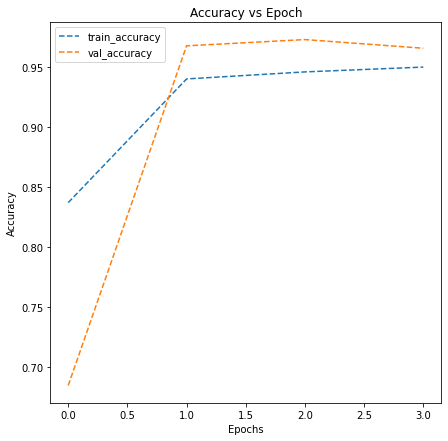

In [42]:
# plotting the accuracies
plot_accuracy(history3)

In [43]:
# Evaluating the model on test data
accuracy3 = model3.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy3[1])

82/82 [==============================] - 5s 53ms/step - loss: 0.1220 - accuracy: 0.9608

 Test_Accuracy:- 0.9607692360877991


<B>Plotting the classification report and confusion matrix

              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1300
           1       0.99      0.93      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



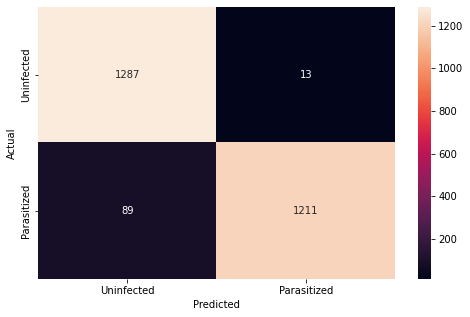

In [44]:
confusion(model3)

**Observations and insights:**
- This model is overfitting. We know this because validation is above accuracy in the accuracy vs epoch graph. This explains why we have .99 for all of our performance metrics, but this is not a good model to use.

<b> Now let us try to use a pretrained model like VGG16 and check how it performs on the data.

### **Pre-trained model (VGG16)**

In [45]:
#Clearing backend
from tensorflow.keras import backend
backend.clear_session()
#Fixing the seed for random number generators
np.random.seed(42)
import random
random.seed(42)
tf.random.set_seed(42)

In [46]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import Model

vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [47]:
transfer_layer = vgg.get_layer('block5_pool')
vgg.trainable=False

# Add classification layers on top of it  
 
x = Flatten()(transfer_layer.output) #Flatten the output from the 3rd block of the VGG16 model
x = Dense(256, activation='relu')(x)

# Similarly add a dense layer with 128 neurons
x = Dropout(0.3)(x)

# Add a dense layer with 64 neurons

x = BatchNormalization()(x)
pred = Dense(64, activation='softmax')(x)

model4 = Model(vgg.input, pred) #Initializing the model

####<b>Compiling the model

In [48]:
# Compiling the model
model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

<b> using callbacks

In [49]:
# Adding Callbacks to the model
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor='val_loss', save_best_only=True)]

<b>Fit and Train the model

In [ ]:
#Fitting the model and running the model for 10 epochs
history4 = model4.fit(train_images,
                      train_labels,
                      batch_size=32,
                      epochs=10,
                      callbacks=callbacks,
                      validation_split=0.2,
                      verbose=1)

#####**Observations and insights:*

<b>Plot the train and validation accuracy

In [ ]:
# plotting the accuracies
plot_accuracy(history4)

#####**Observations and insights: The last model using VGG16 does not increase the accuracy of the model.**

*   What can be observed from the validation and train curves?

####<b> Evaluating the model

In [ ]:
# Evaluating the model on test data
accuracy = model4.evaluate(test_images, test_labels, verbose=1)
print('\n', 'Test_Accuracy:-', accuracy[1])

<b>Plotting the classification report and confusion matrix

In [ ]:
# Plot the confusion matrix and generate a classification report for the model
confusion(model4)

####<b>Think about it:</b>
*  What observations and insights can be drawn from the confusion matrix and classification report?
*  Choose the model with the best accuracy scores from all the above models and save it as a final model.


In [ ]:
#Saving the final model
final_model = model

###<b> Observations and Conclusions drawn from the final model: 
- It is unsurprising in this project that the model with the highest accuracy is the most simple model. Since this is a relatively simple classification task, complex CNN architecture was not needed to accomplish this task.



**Improvements that can be done:**<br>


- The model performance can be improved slightly using pre-trained models and different CNN architecture. We see that a basic CNN architecture gives an accuracy of 0.977 and a CNN with a more complex architecture from this notebook gave an accuracy of 0.984.
- In this case, data augmentation through image generation was not a huge benefit to the performance of the metrics.


- I might try to build a model using these HSV images and compare them with my other models.

### **Insights**
- I propose to use model 1 which has 3 convolutional layers and 32 filters. This model gave the best accuracy which right now is the most important metric.